In [ ]:
#pip install pandas
#pip install openpyxl
#pip install matplotlib
#pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
hotels = pd.read_excel('hotels.xlsx')

In [8]:
preferences = pd.read_excel('preferences.xlsx')

In [9]:
guests = pd.read_excel('guests.xlsx')

In [10]:
files = [hotels, preferences, guests]

In [11]:
for file in files[:2]:
    file = file.iloc[:, 1:]

In [12]:
guests.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [78]:
min(hotels['price']) #min price for defining categories of price

50

In [30]:
max(hotels['price']) #max price for defining categories of price

299

4 categories from 50 to 300 (for beauty numbers) means that we divide categories for 250/4 = 62,5 buckets:
50 - 112,5 
112, 5 - 175
175-237,5
237,5 - 300

In [115]:
categories = ['Economy', 'Affordable', 'Premium', 'Luxury']

In [137]:
def df_visualisation(merged_distribution):
    pivot_for_visualisation = merged_distribution.pivot_table(values= ['guest', 'rooms', 'price', 'price_final'], index='hotel', 
                                                          aggfunc={'guest':'count', 'rooms':'mean', 'price':'mean', 'price_final':'sum'})
    pivot_for_visualisation = pivot_for_visualisation.reset_index()
    # Assign price categories to hotels and order categories according to lowest and highest 
    conditions = [
    (pivot_for_visualisation['price'] >= 50) & (pivot_for_visualisation['price'] < 112.5),
    (pivot_for_visualisation['price'] >= 112.5) & (pivot_for_visualisation['price'] < 175),
    (pivot_for_visualisation['price'] >= 175) & (pivot_for_visualisation['price'] < 237.5),
    (pivot_for_visualisation['price'] >= 237.5)]
    
    pivot_for_visualisation['price_category'] = np.select(conditions, categories, default='Unknown')
    pivot_for_visualisation['price_category'] = pd.Categorical(pivot_for_visualisation['price_category'], categories=categories, ordered=True)
    
    pivot_for_visualisation['check_in_percentage'] = pivot_for_visualisation['guest'] / pivot_for_visualisation['rooms']
    return pivot_for_visualisation

In [13]:
# Universal color palette for all charts
color_palette = ['#88c4e8', '#ff9b85', '#ffce64', '#7c8eb1']

# Function for building a bar chart with labels
def plot_bar_chart(data, title, xlabel, ylabel, categories=None):
    plt.figure(figsize=(6, 4))  # Size
    ax = data.plot(kind='bar', color=color_palette)  # Column chart with universal color palette
    
    # Adding captions to columns
    for p in ax.patches:
        value = round(p.get_height(), 2)  # Rounding the number for labeling
        ax.annotate(f'{value}',  # Text with numbers
                    (p.get_x() + p.get_width() / 2, p.get_height()),  # Central position
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
    
    # Bar chart settings
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    if categories:
        plt.xticks(ticks=range(len(categories)), labels=categories)  # Label X
    plt.xticks(rotation=45, ha='right')  # Rotate labels of X
    plt.tight_layout()  # Improved element layout
    plt.show()

# Function for creating a scatterplot and adding labels to key points. highlight_points - list of indices for points that should be signed (default None)
# xticks - X-axis labels (default None)
def plot_scatter(x, y, title, xlabel, ylabel, highlight_points=None, color='green', xticks=None):
    # Building a scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.5, color=color)

    # Set up X-axis ticks (if xticks is passed)
    if xticks is not None:
        plt.xticks(xticks)

    # Sign key points if they are transmitted
    if highlight_points is not None:
        for idx in highlight_points:
            plt.text(x[idx], y[idx], f'({y[idx]:.2f})', fontsize=7, ha='center', va='bottom', color='red')

    # Graph settings
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Graph depiction
    plt.tight_layout()
    plt.show()

# Universal function for plotting all graphs
def plot_all_graphs(pivot_for_visualisation, categories):
    # Data for graphs
    data_list = [
        (pivot_for_visualisation['price_category'].value_counts().reindex(categories), 
         'Hotels Price Distribution', 'Price Category', 'Amount of Hotels', categories),
        
        (pivot_for_visualisation.groupby('price_category')['guest'].sum(), 
         'Distribution of Guests by Price Category', 'Price Category', 'Total Number of Guests', categories),
        
        (pivot_for_visualisation.groupby('price_category')['price_final'].sum(), 
         'Total Revenue Distribution', 'Price Category', 'Total Revenue', categories)
    ]

    # Loop to build all bar charts
    for data, title, xlabel, ylabel, categories in data_list:
        plot_bar_chart(data, title, xlabel, ylabel, categories)

    # Box plot
    plt.figure(figsize=(6, 4))
    ax = plt.boxplot(pivot_for_visualisation['price_final'], patch_artist=True, notch=True, vert=False, widths=0.7, 
                     medianprops=dict(color='brown', linewidth=2), flierprops=dict(marker='o', color='green', markersize=10, alpha=0.8),
                    boxprops=dict(facecolor='beige', color='brown'))

    plt.title('Distribution of Hotel Revenue (Box Plot)', fontsize=12)
    plt.xlabel('Revenue', fontsize=10)
    plt.yticks([1], ['Hotels'])
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add median
    median_value = round(pivot_for_visualisation['price_final'].median(), 2)
    plt.annotate(f'Median: {median_value}', xy=(median_value, 1), xytext=(median_value + 100, 1.05),
                 arrowprops=dict(arrowstyle="->", color='brown'), fontsize=12, color='brown')

    plt.tight_layout()
    plt.show()
    
    # Revenue distribution by number of guests
    x = pivot_for_visualisation['guest']
    y = pivot_for_visualisation['price_final']

    # Finding key point indices for signatures (minimum and maximum)
    key_points_indices = [x.idxmax(), x.idxmin(), y.idxmax(), y.idxmin()]

    # Calling a function to distribute revenue by number of guests
    plot_scatter(x, y, 
                 title='Scatter Plot of Price Distribution According to Number of Guests',
                 xlabel='Number of Guests',
                 ylabel='Total Revenue of Hotel',
                 highlight_points=key_points_indices, 
                 color='green',
                 xticks=range(int(x.min()), int(x.max())+1, 1))
    
    # Occupancy rate by hotel
    x = pivot_for_visualisation.index  # hotel indexes
    y = pivot_for_visualisation['check_in_percentage']

    # We find the indexes of the 3 most unoccupied hotels
    bottom_3_hotels = pivot_for_visualisation.nsmallest(3, 'check_in_percentage')
    
    # Calling the function for the second graph
    plot_scatter(x, y, 
                 title='Hotel Check-in Percentage',
                 xlabel='Hotel Index',
                 ylabel='Check-in Percentage',
                 highlight_points=bottom_3_hotels.index,
                 color='green',
                 xticks=[])

In [222]:
final_guests

,guest,hotel,priority,price,rooms,index,discount,price_final
0,guest_1,hotel_168,1,298.0,13.0,0,0.09,271.18
1,guest_2,hotel_369,1,133.0,6.0,1,0.00,133.00
2,guest_3,hotel_157,1,65.0,6.0,2,0.07,60.45
3,guest_4,hotel_235,1,136.0,5.0,3,0.00,136.00
4,guest_5,hotel_121,1,56.0,15.0,4,0.10,50.40
...,...,...,...,...,...,...,...,...
3995,guest_3770,hotel_26,0,55.0,19.0,3769,0.06,51.70
3996,guest_3789,hotel_167,0,55.0,9.0,3788,0.19,44.55
3997,guest_3795,hotel_26,0,55.0,19.0,3794,0.18,45.10
3998,guest_3943,hotel_26,0,55.0,19.0,3942,0.13,47.85


In [149]:
def plot_satisfaction(merged_distribution):
    # We aggregate preferences by guests, creating a list of hotels by priority
    df_guest_preferences = preferences.groupby('guest')['hotel'].apply(list).reset_index()
    df_guest_preferences.columns = ['guest', 'priority']
    
    # We merge data of preferences and actual settlement
    df_for_satisfaction = pd.merge(df_guest_preferences, merged_distribution, on='guest')
    
    # Function for calculating satisfaction
    def calculate_satisfaction(row):
        # Find the index of the actual hotel in the list of preferences
        preferences_list = row['priority']
        
        if row['hotel'] in preferences_list:
            satisfaction = 1 - preferences_list.index(row['hotel']) / len(preferences_list)
        else:
            satisfaction = 0  # If the hotel is not on the list of preferences, then satisfaction is minimal
        return satisfaction
    
    # We apply the function for each guest
    df_for_satisfaction['satisfaction'] = df_for_satisfaction.apply(calculate_satisfaction, axis=1)
    
    # A histogram to display the distribution of satisfaction
    plt.figure(figsize=(6, 4))
    plt.hist(df_for_satisfaction['satisfaction'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Guest Satisfaction', fontsize=14)
    plt.xlabel('Satisfaction Level', fontsize=12)
    plt.ylabel('Number of Guests', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # Seaborn graph
    # We aggregate the data: for each hotel we calculate the average guest satisfaction
    hotel_satisfaction = df_for_satisfaction.groupby('hotel')['satisfaction'].mean()
    
    # Let's prepare the data for display
    data = hotel_satisfaction.values.reshape(1, -1)
    
    # We build a graph without axes and labels
    plt.figure(figsize=(14, 2))  # We reduce the height, since there are no signatures
    plt.imshow(data, aspect='auto', cmap='YlGnBu', interpolation='nearest')
    
    # Adding a color scale
    plt.colorbar(label='Satisfaction')
    
    # Removing the axes
    plt.xticks([])  
    plt.yticks([])
    
    # Adding a title
    plt.title('Guest Satisfaction by Hotel', fontsize=16)
    
    # Improving chart interpretation
    plt.tight_layout()
    
    # Graph depiction
    plt.show()

In [8]:
hotels[hotels['rooms'] == 0] #just in case

,hotel,rooms,price


In [138]:
hotels_new = pd.DataFrame(columns = ['room_number', 'hotel', 'rooms', 'price'])
for i in hotels['hotel']:
    room_numbers = hotels[hotels['hotel'] == i]['rooms'].values[0]
    price = hotels[hotels['hotel'] == i]['price'].values[0]
    rooms = hotels[hotels['hotel'] == i]['price'].values[0]
    a = 0
    for j in range(room_numbers):
        a +=1 
        hotels_new.loc[len(hotels_new)] = [a, i, room_numbers, price]
    hotels_new

In [139]:
random_numbers = np.random.permutation(len(hotels_new))

In [140]:
hotels_new['random_number'] = random_numbers

In [141]:
hotels_new2 = hotels_new[hotels_new['random_number'] <= 3999]

In [142]:
merged_distribution = pd.merge(hotels_new2, guests, left_on = 'random_number', right_on = 'index', how = 'left')

In [143]:
merged_distribution['price_final'] = merged_distribution['price'] * (1 - merged_distribution['discount'])

New price order - my own creation to increase total revenue, still it will increase reputation risks and damage guests' loyalty 

In [67]:
# hotels_new_price_order = hotels_new.sort_values(by='price', ascending=False)

In [68]:
# hotels_new_price_order = hotels_new_price_order.head(4000)

In [69]:
# random_numbers2 = np.random.permutation(len(hotels_new_price_order))

In [70]:
# hotels_new_price_order['random_number'] = random_numbers2

In [71]:
# merged_distribution_order = pd.merge(hotels_new_price_order, guests, left_on = 'random_number', right_on = 'index', how = 'left')

In [94]:
# merged_distribution_order['price_final'] = merged_distribution_order['price'] * (1 - merged_distribution_order['discount'])

Visualisation part

In [144]:
pivot_for_visualisation = df_visualisation(merged_distribution)

C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['guest'].sum(),
C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['price_final'].sum(),


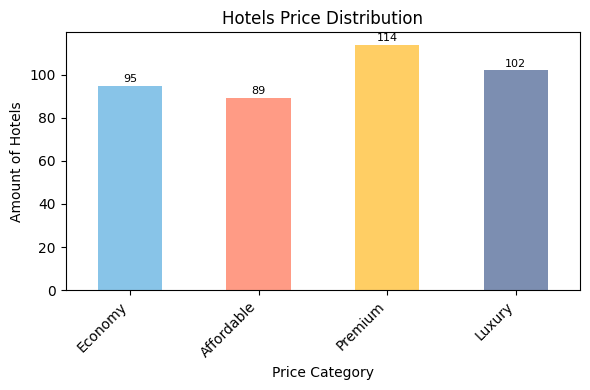

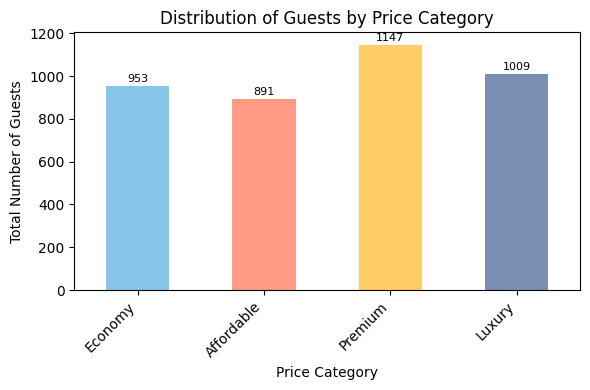

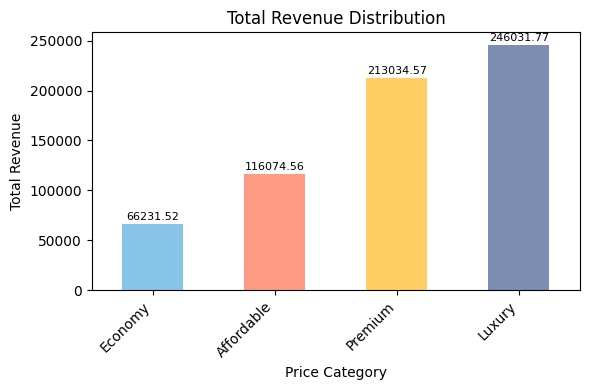

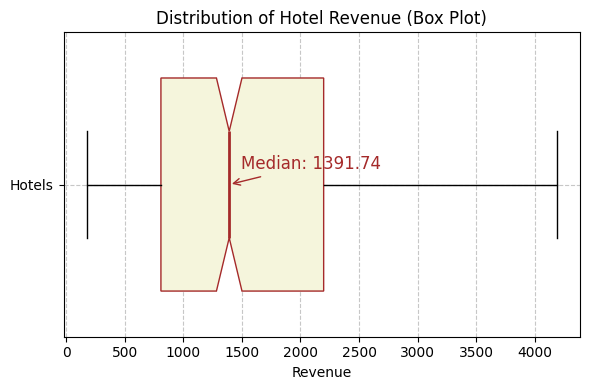

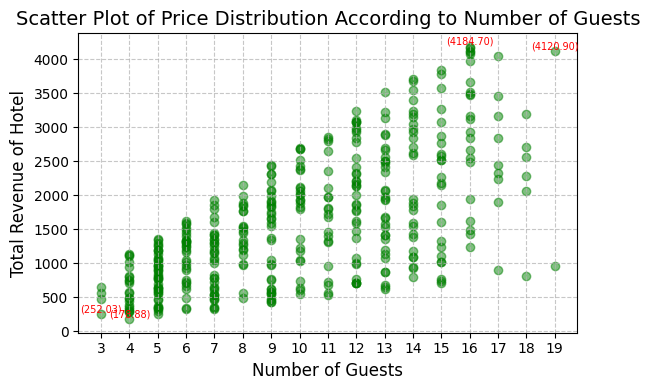

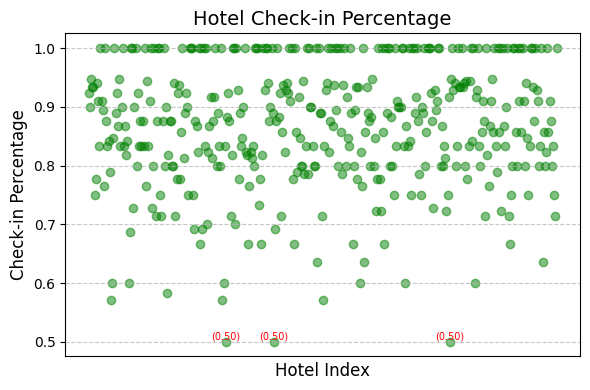

In [145]:
plot_all_graphs(pivot_for_visualisation, categories)

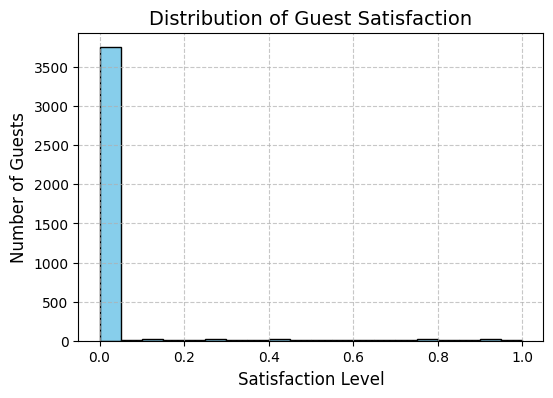

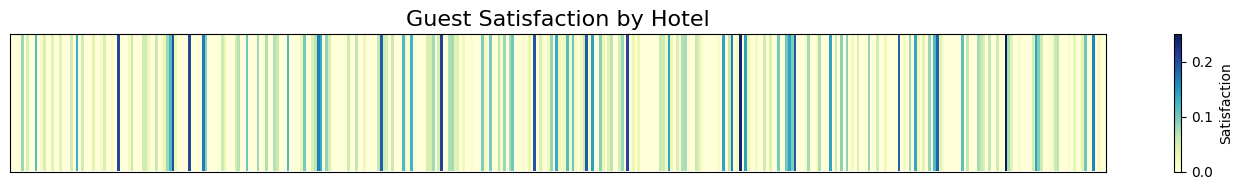

In [150]:
plot_satisfaction(merged_distribution)

Part 2

In [23]:
#hotels_rest['rest'] = hotels_rest['rooms'] - hotels_rest['guest']

In [225]:
list_priorities= preferences['priority'].unique().tolist()

In [226]:
checked_in_guests = pd.DataFrame()
hotels_rest = hotels
hotels_rest['rest'] = hotels['rooms']
hotels_rest['guests'] = 0
not_checked_in_guests = guests
while not not_checked_in_guests.empty:
    for priority in list_priorities:
        start_df = preferences[(preferences['priority'] == priority) & preferences['guest'].isin(not_checked_in_guests['guest']) ]
        start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
        df_hotels = pd.merge(start_df, hotels_rest, on = 'hotel', how = 'left')
        checked_in_guests = pd.concat([checked_in_guests, df_hotels[df_hotels['rn'] <= df_hotels['rest']]], ignore_index=True)
        not_checked_in_guests = df_hotels[df_hotels['rn'] > df_hotels['rest']]
        
        hotels_rest = checked_in_guests.pivot_table(values= ['guest', 'rooms', 'price'], index='hotel', aggfunc={'guest':'count', 'rooms':'mean', 'price':'mean'})
        hotels_rest = hotels_rest.rename(columns={'guest': 'guests'})
        hotels_rest['rest'] = hotels_rest['rooms'] - hotels_rest['guests']
        hotels_rest = hotels_rest.reset_index()
        print(priority, len(checked_in_guests))

C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df['rn'] = start_df.groupby('hotel').cumcount() + 1
C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\1903805619.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

1 3398
2 3706
3 3828
4 3890
5 3924
6 3941
7 3952
8 3959
9 3964
10 3966
11 3967
12 3971
13 3971
14 3971
15 3972
16 3972
17 3972
18 3972
19 3972
20 3972
21 3972
22 3972
23 3972
24 3972
25 3972
26 3972
27 3972
28 3972
29 3972
30 3972
31 3972
32 3972
33 3972
34 3972
35 3972
36 3972
37 3972
38 3972
39 3972
40 3972
41 3972
42 3972
43 3972
44 3972
45 3972
46 3972
47 3972
48 3972
49 3972


In [227]:
check_df = preferences[~preferences['guest'].isin(checked_in_guests['guest'])] #these guests will be distributed according to the cheapest hotels

In [228]:
guests_leftovers = check_df['guest'].unique().tolist()

In [229]:
x = len(guests_leftovers)

In [230]:
hotels_for_leftovers = hotels_rest[hotels_rest['rest'] > 0].sort_values('price') #additional marketing step to let leftovers check in in the cheapest hotels

In [231]:
rooms_leftovers = pd.merge(hotels_new, hotels_for_leftovers, on = 'hotel', how = 'inner')

In [232]:
rooms_leftovers = rooms_leftovers[rooms_leftovers['room_number'] > rooms_leftovers['guests']]

In [233]:
rooms_leftovers = rooms_leftovers.sort_values('price_x')[:x]

In [234]:
rooms_leftovers['guest'] = guests_leftovers

In [235]:
rooms_leftovers['priority'] = 0

In [236]:
rooms_leftovers = rooms_leftovers.rename(columns={'price_y': 'price'})

In [237]:
rooms_leftovers = rooms_leftovers.rename(columns={'rooms_x': 'rooms'})

In [238]:
checked_in_guests = checked_in_guests[['guest', 'hotel', 'price', 'rooms']]

In [239]:
rooms_leftovers = rooms_leftovers[['guest', 'hotel', 'price', 'rooms']]

In [240]:
final_guests = pd.concat([checked_in_guests, rooms_leftovers], ignore_index=True)

In [241]:
final_guests = pd.merge(final_guests, guests, on = 'guest', how = 'left')

In [242]:
final_guests['price_final'] = final_guests['price'] * (1 - final_guests['discount'])

In [243]:
pivot_for_visualisation = df_visualisation(final_guests)

C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['guest'].sum(),
C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['price_final'].sum(),


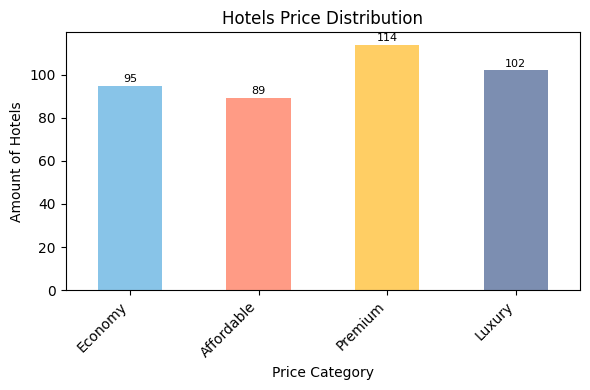

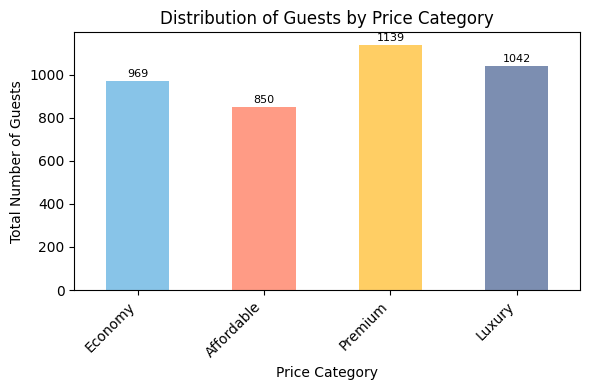

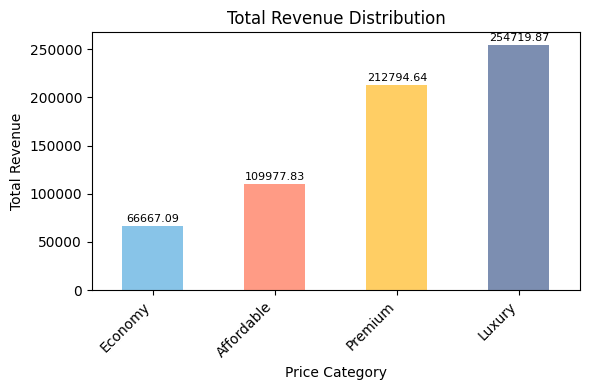

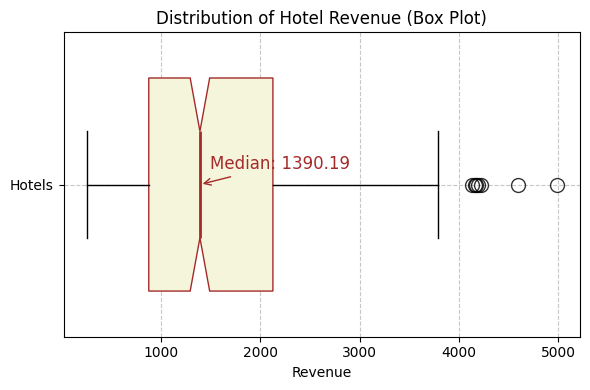

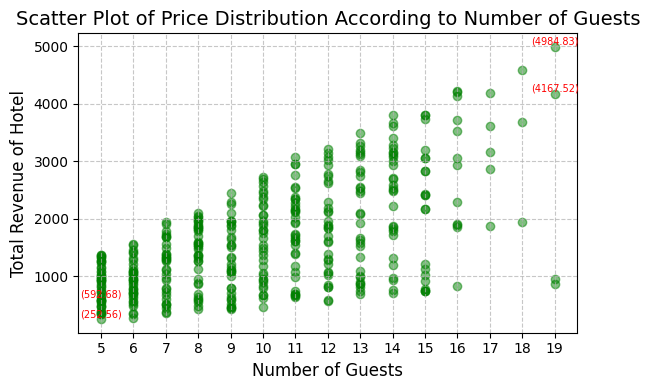

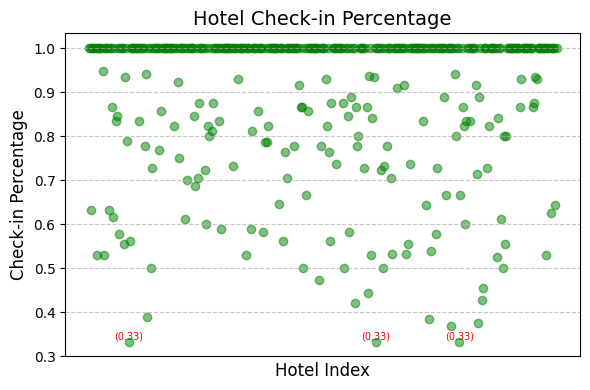

In [244]:
plot_all_graphs(pivot_for_visualisation, categories)

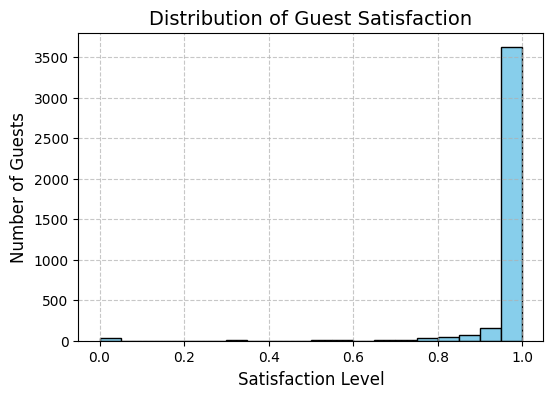

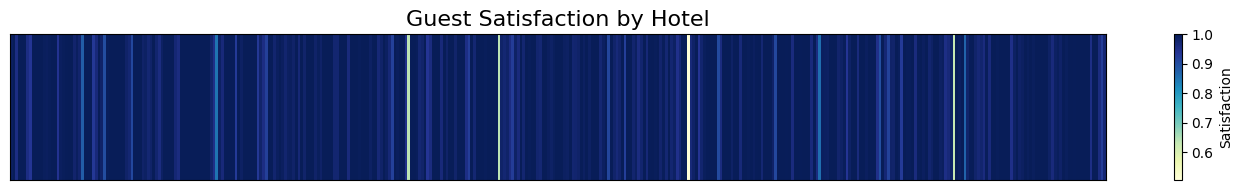

In [245]:
plot_satisfaction(final_guests)

Part 3

In [ ]:
1. Заселяем сначала все самые дешевые отели - сортируем таблицу с комнатами hotels_new по цене
2. Для каждого отеля по порядку: получить список гостей исходя из порядка и приоритета

создать датасет для каждого отеля - временный 
создать совокупный датасет

для каждого отеля отобрать только тех гостей, у которых он встречается в приоритетах
hotel - guest - priority - *rn

отсортировать по приоритету, затем по гостю 
пронумеровать и оставить только тех, кто меньше количества комнат 

также сделать датасеты с заселенными и незаселенными гостями, чтобы в новой итерации обращаться к измененному списку гостей 
то есть датасет с гостями будет меняться

In [246]:
priorities = []
for i in range(1, max(preferences['priority']) + 1):
    priorities.append(i)

In [247]:
hotels_new = hotels_new.sort_values(by = ['price', 'hotel', 'room_number'])

In [248]:
hotels = hotels.sort_values('price')

In [251]:
hotels_draft = hotels.copy()
df_draft = pd.DataFrame()
dict_hotels = hotels_draft.groupby('price')['hotel'].apply(list).to_dict()
checked_in_full = pd.DataFrame(columns = ['guest'])
for key in dict_hotels:
    for hotel in dict_hotels[key]:
        df_draft_0 = preferences[(preferences['hotel'] == hotel) & ~preferences['guest'].isin(checked_in_full['guest'])] #исключаем тех, кого заселили
        df_draft = pd.concat([df_draft, df_draft_0], ignore_index=True)
    for priority in priorities:
        df_priority = df_draft[(df_draft['priority'] == priority) & ~df_draft['guest'].isin(checked_in_full['guest'])] #исключить тех, кого заселили
        for hotel in dict_hotels[key]:
            checked_in_guests = df_priority[df_priority['hotel'] == hotel]
            free_rooms = hotels_draft[hotels_draft['hotel'] == hotel]['rooms'].values[0]
            checked_in_guests = checked_in_guests[:free_rooms]
            checked_in_full = pd.concat([checked_in_full, checked_in_guests], ignore_index=True)
            hotels_draft.loc[hotels_draft['hotel'] == hotel, 'rooms'] -= len(checked_in_guests)
    print(key, dict_hotels[key], len(checked_in_full), 'done')       
    df_draft = pd.DataFrame()

50 ['hotel_49', 'hotel_190'] 29 done
52 ['hotel_301', 'hotel_354'] 47 done
53 ['hotel_24'] 56 done
54 ['hotel_47', 'hotel_23', 'hotel_365', 'hotel_321'] 115 done
55 ['hotel_167', 'hotel_26'] 143 done
56 ['hotel_320', 'hotel_15', 'hotel_350', 'hotel_53', 'hotel_121'] 203 done
57 ['hotel_249', 'hotel_242'] 232 done
58 ['hotel_6'] 242 done
59 ['hotel_92', 'hotel_144'] 267 done
60 ['hotel_247'] 281 done
61 ['hotel_22'] 298 done
64 ['hotel_252'] 311 done
65 ['hotel_157', 'hotel_155'] 324 done
66 ['hotel_135', 'hotel_273', 'hotel_120'] 360 done
67 ['hotel_109'] 371 done
68 ['hotel_397', 'hotel_262', 'hotel_160'] 409 done
69 ['hotel_134', 'hotel_7'] 430 done
71 ['hotel_283'] 439 done
72 ['hotel_174'] 452 done
73 ['hotel_102', 'hotel_268', 'hotel_104', 'hotel_279', 'hotel_189'] 515 done
74 ['hotel_305', 'hotel_339'] 543 done
75 ['hotel_360', 'hotel_79', 'hotel_88', 'hotel_337'] 582 done
76 ['hotel_295', 'hotel_224'] 614 done
77 ['hotel_77'] 626 done
78 ['hotel_280'] 638 done
79 ['hotel_177', '

In [202]:
leftovers_expensive = preferences[~preferences['guest'].isin(checked_in_full['guest'])]['guest'].unique() #3990 - 10 guests without hotel - why?

In [203]:
#Check 10 guests and check in them in expensive hotels

In [205]:
df_for_leftovers_expensive = pd.merge(hotels_new, check[check['guest'] != check['rooms']], on = 'hotel', how = 'inner')

In [206]:
df_for_leftovers_expensive = df_for_leftovers_expensive[df_for_leftovers_expensive['room_number'] <= df_for_leftovers_expensive['guest']]

In [207]:
df_for_leftovers_expensive = df_for_leftovers_expensive.sort_values('price_y')

In [208]:
df_for_leftovers_expensive = df_for_leftovers_expensive[:len(leftovers_expensive)]

In [209]:
df_for_leftovers_expensive['leftovers'] = leftovers_expensive

In [210]:
df_for_leftovers_expensive = df_for_leftovers_expensive[['leftovers', 'hotel']]

In [211]:
df_for_leftovers_expensive['priority'] = 0

In [212]:
df_for_leftovers_expensive = df_for_leftovers_expensive.rename(columns={'leftovers': 'guest'})

In [213]:
checked_in_full_final = pd.concat([checked_in_full, df_for_leftovers_expensive])

In [214]:
checked_in_full_final = pd.merge(checked_in_full_final, guests, on = 'guest', how = 'left')

In [215]:
checked_in_full_final = pd.merge(checked_in_full_final, hotels, on = 'hotel', how = 'left')

In [216]:
checked_in_full_final['price_final'] = checked_in_full_final['price'] * (1 - checked_in_full_final['discount'])

In [253]:
checked_in_full_final = checked_in_full_final.rename(columns={'priority': 'priority_number'})

In [254]:
pivot_for_visualisation = df_visualisation(checked_in_full_final)

C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['guest'].sum(),
C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['price_final'].sum(),


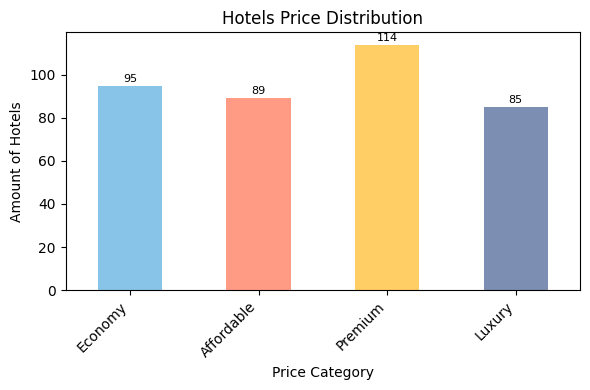

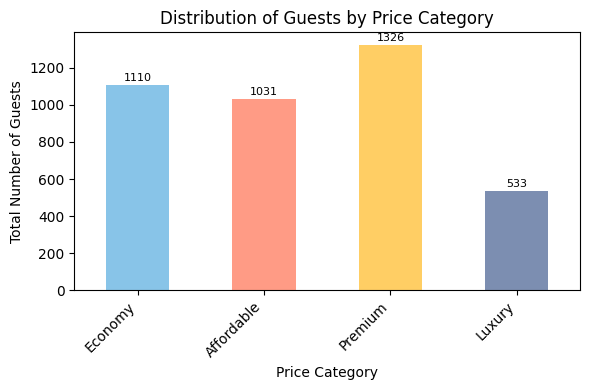

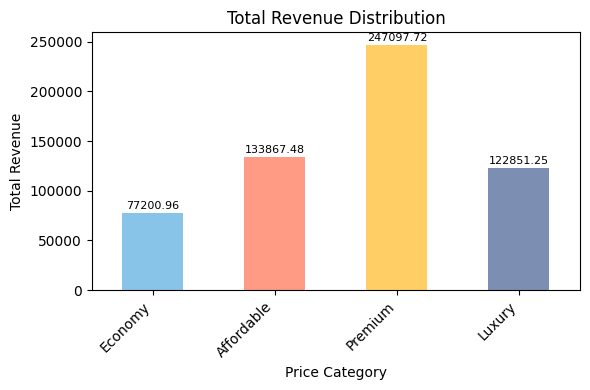

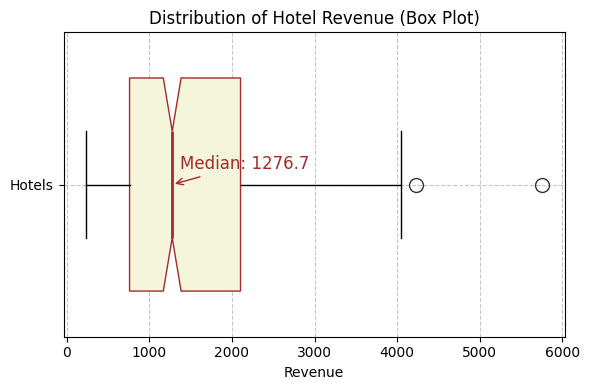

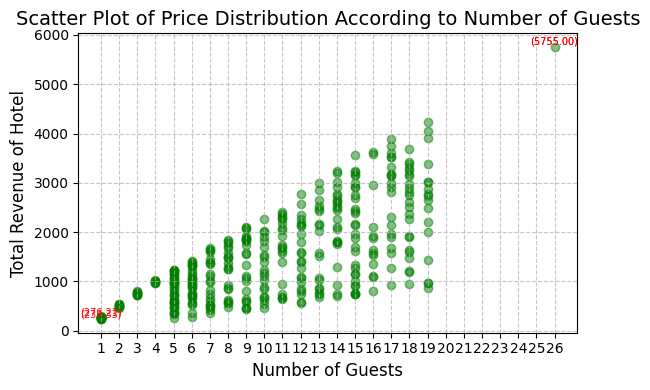

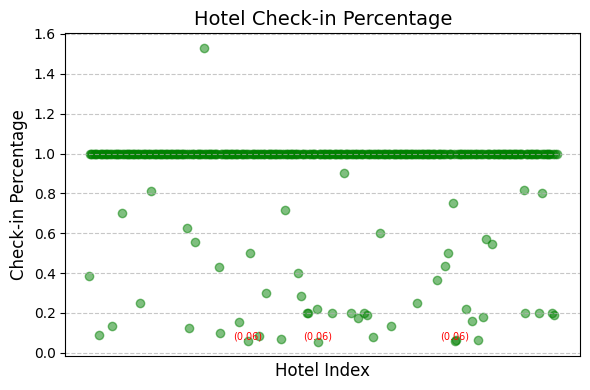

In [255]:
plot_all_graphs(pivot_for_visualisation, categories)

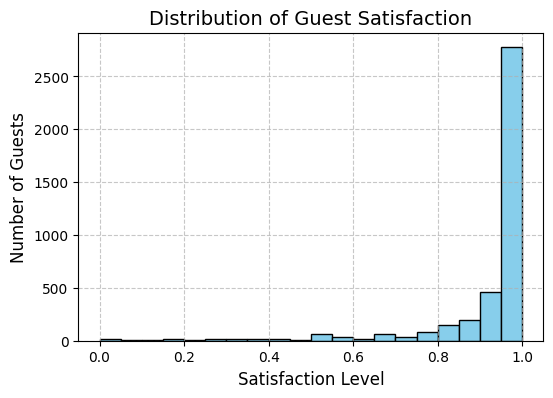

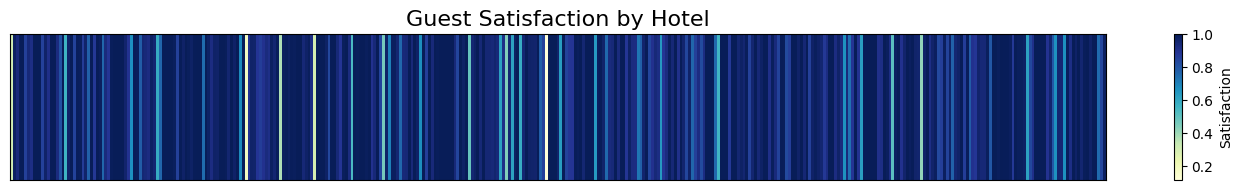

In [256]:
plot_satisfaction(checked_in_full_final)

Part 4

In [ ]:
#sorted by availability starting with the most roomy hotel 

In [257]:
priorities = []
for i in range(1, max(preferences['priority']) + 1):
    priorities.append(i)

In [258]:
hotels = hotels.sort_values('rooms', ascending=False)

In [259]:
hotels_draft = hotels.copy()
df_draft = pd.DataFrame()
dict_hotels = hotels_draft.groupby('rooms')['hotel'].apply(list).to_dict()
checked_in_full = pd.DataFrame(columns = ['guest'])
for key in sorted(dict_hotels, reverse=True):
    for hotel in dict_hotels[key]:
        df_draft_0 = preferences[(preferences['hotel'] == hotel) & ~preferences['guest'].isin(checked_in_full['guest'])] #исключаем тех, кого заселили
        df_draft = pd.concat([df_draft, df_draft_0], ignore_index=True)
    for priority in priorities:
        df_priority = df_draft[(df_draft['priority'] == priority) & ~df_draft['guest'].isin(checked_in_full['guest'])] #исключить тех, кого заселили
        for hotel in dict_hotels[key]:
            checked_in_guests = df_priority[df_priority['hotel'] == hotel]
            free_rooms = hotels_draft[hotels_draft['hotel'] == hotel]['rooms'].values[0]
            checked_in_guests = checked_in_guests[:free_rooms]
            checked_in_full = pd.concat([checked_in_full, checked_in_guests], ignore_index=True)
            hotels_draft.loc[hotels_draft['hotel'] == hotel, 'rooms'] -= len(checked_in_guests)
    print(key, dict_hotels[key], len(checked_in_full), 'done')       
    df_draft = pd.DataFrame()

19 ['hotel_129', 'hotel_276', 'hotel_115', 'hotel_11', 'hotel_303', 'hotel_394', 'hotel_29', 'hotel_26', 'hotel_53', 'hotel_49', 'hotel_317', 'hotel_52', 'hotel_366', 'hotel_114', 'hotel_378', 'hotel_346', 'hotel_100', 'hotel_122'] 342 done
18 ['hotel_56', 'hotel_392', 'hotel_277', 'hotel_144', 'hotel_278', 'hotel_2', 'hotel_344', 'hotel_173', 'hotel_12', 'hotel_189', 'hotel_39', 'hotel_305', 'hotel_266', 'hotel_356', 'hotel_372', 'hotel_142', 'hotel_126', 'hotel_17', 'hotel_374', 'hotel_313', 'hotel_59', 'hotel_264', 'hotel_4', 'hotel_328', 'hotel_323', 'hotel_32'] 810 done
17 ['hotel_251', 'hotel_143', 'hotel_245', 'hotel_331', 'hotel_284', 'hotel_90', 'hotel_282', 'hotel_191', 'hotel_237', 'hotel_46', 'hotel_222', 'hotel_380', 'hotel_22', 'hotel_388', 'hotel_308', 'hotel_75', 'hotel_25', 'hotel_183', 'hotel_165', 'hotel_316', 'hotel_200', 'hotel_223', 'hotel_110', 'hotel_105', 'hotel_205', 'hotel_309'] 1252 done
16 ['hotel_249', 'hotel_399', 'hotel_194', 'hotel_285', 'hotel_94', 'ho

In [261]:
checked_in_full = checked_in_full.rename(columns={'priority': 'priority_number'})

In [263]:
checked_in_full_final = pd.merge(checked_in_full, guests, on = 'guest', how = 'left')

In [264]:
checked_in_full_final = pd.merge(checked_in_full_final, hotels, on = 'hotel', how = 'left')

In [265]:
checked_in_full_final['price_final'] = checked_in_full_final['price'] * (1 - checked_in_full_final['discount'])

In [266]:
pivot_for_visualisation = df_visualisation(checked_in_full_final)

C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['guest'].sum(),
C:\Users\Mi\AppData\Local\Temp\ipykernel_10828\3180807643.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (pivot_for_visualisation.groupby('price_category')['price_final'].sum(),


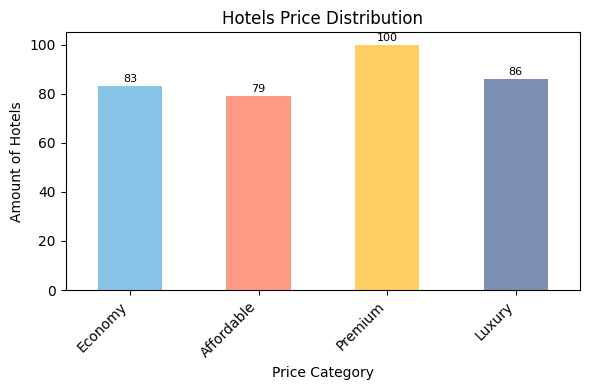

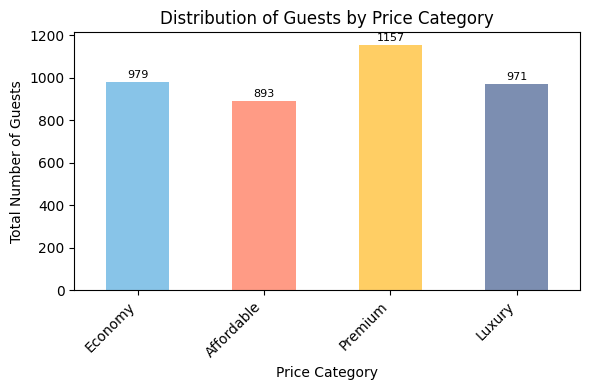

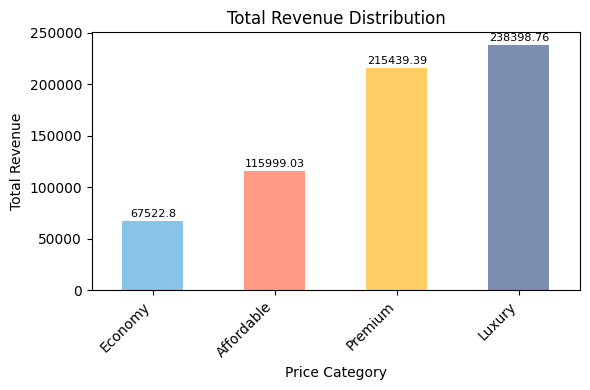

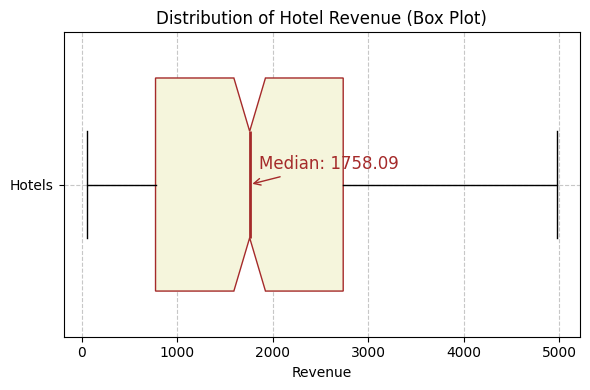

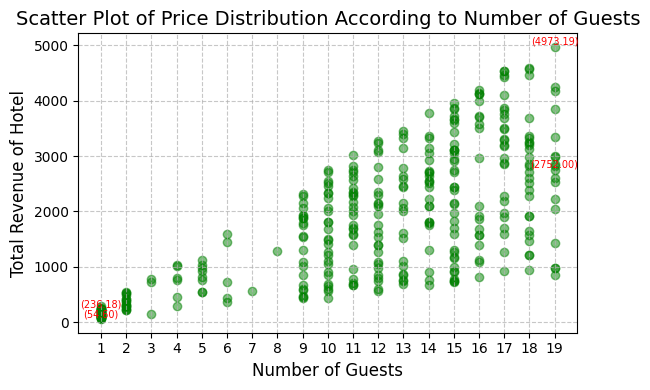

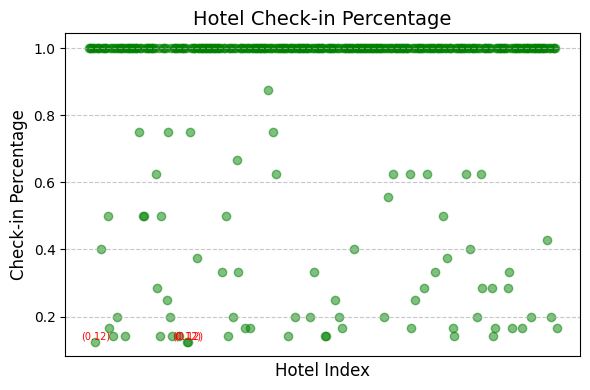

In [267]:
plot_all_graphs(pivot_for_visualisation, categories)

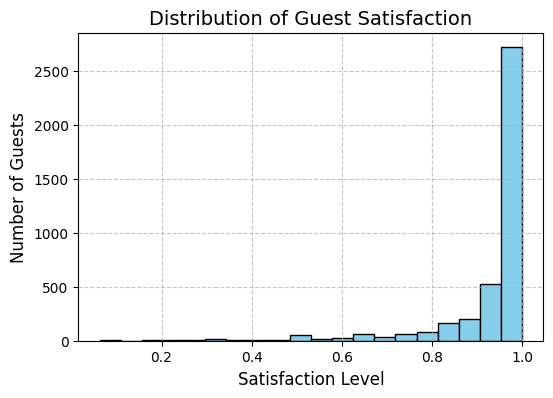

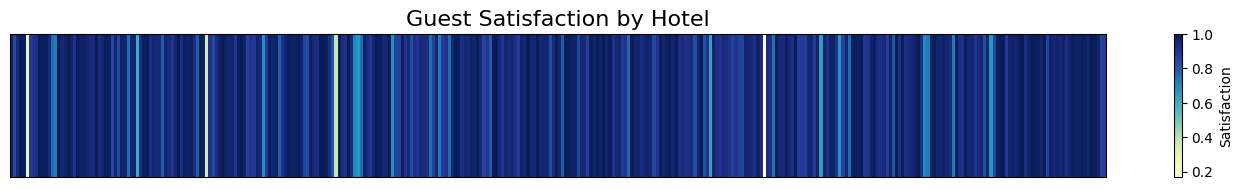

In [268]:
plot_satisfaction(checked_in_full_final)

Все, что дальше - не нужно